In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import Spectral
from pyleoclim import Spectral
import pickle
from tqdm import tqdm

from matplotlib.backends.backend_pdf import PdfPages
from scipy import signal
import nitime.algorithms as tsa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## A test with SOI

796


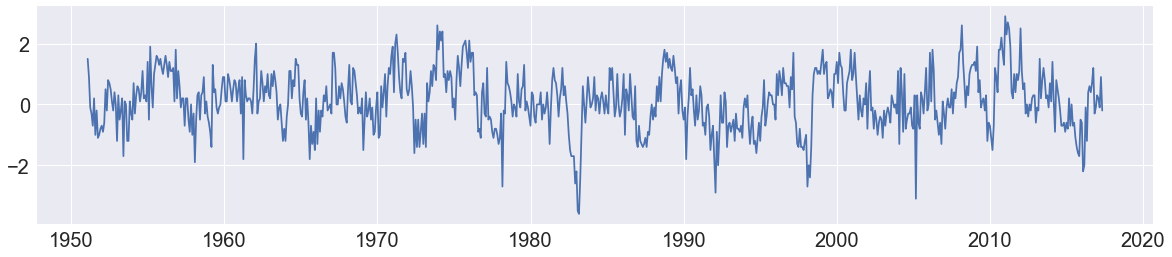

In [3]:
import pandas as pd

data = pd.read_csv('./soi_data.csv')

Xo_evenly = np.asarray(data['SOI'])
to_evenly = np.asarray(data['Year']) + np.asarray(data['Month'])/12

sns.set(style="darkgrid", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to_evenly, Xo_evenly)  # plot the original time seires
print(np.size(Xo_evenly))

696


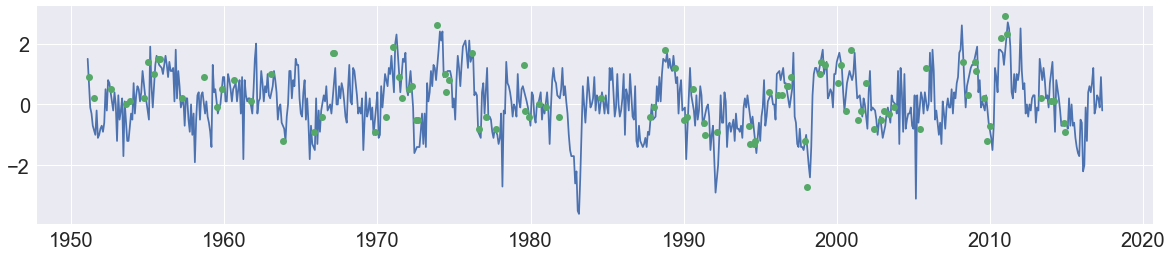

In [4]:
# generate some points to be deleted

import random
random.seed(2333)
n_del = 100
deleted_idx = random.sample(range(np.size(to_evenly)), n_del)

to_unevenly =  np.delete(to_evenly, deleted_idx)
Xo_unevenly =  np.delete(Xo_evenly, deleted_idx)

sns.set(style="darkgrid", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to_unevenly, Xo_unevenly)  # plot the unevenly sampled time seires
plt.plot(to_evenly[deleted_idx], Xo_evenly[deleted_idx], 'o')  # plot the deleted points
print(np.size(Xo_unevenly))

## Check AR1 model

persistence: 0.196995253242


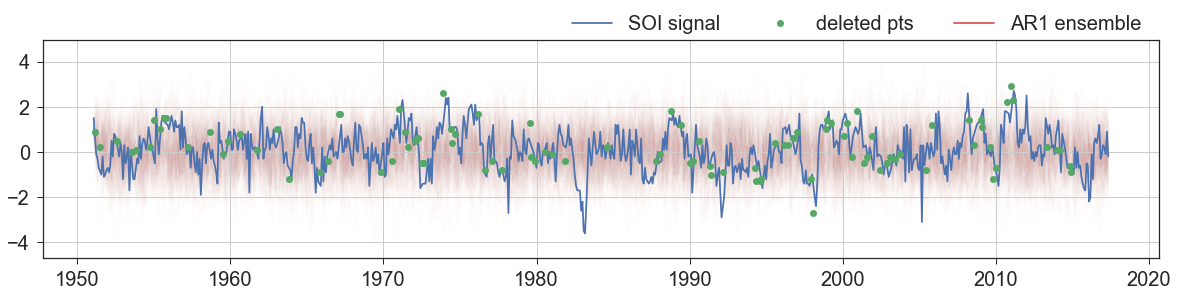

In [43]:
wa = Spectral.WaveletAnalysis()
Xo_stdd = wa.preprocess(Xo_unevenly)
tauest = wa.tau_estimation(Xo_unevenly, to_unevenly)
print('persistence:', tauest)

nMC = 100
ar1 = np.ndarray(shape=(nMC, np.size(to_unevenly)))
red_var = np.zeros(nMC)
for i in range(nMC):
    ar1[i, :] = wa.ar1_model(to_unevenly, tauest)

sns.set(style="ticks", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to_unevenly, Xo_unevenly, label='SOI signal')  # plot the unevenly sampled time seires
plt.plot(to_evenly[deleted_idx], Xo_evenly[deleted_idx], 'o', label='deleted pts')  # plot the deleted points    

for i in range(nMC):
    plt.plot(to_unevenly, ar1[i, :], color=sns.xkcd_rgb["pale red"], alpha=0.01, zorder=-1)

plt.plot(np.nan, np.nan, color=sns.xkcd_rgb["pale red"], alpha=1, label='AR1 ensemble') 
plt.grid()
plt.legend(fontsize=20, bbox_to_anchor=(1, 1.2), loc='upper right', ncol=3)
plt.savefig('./checkTS.png')

## Now we have unevenly spaced time series, and let's WWZ

In [45]:
# parameters setup
tau = np.linspace(np.min(to_evenly), np.max(to_evenly), 101)
freqs = np.linspace(1/50, 2, 101)
dcon = 1/(8*np.pi**2)  # the decay constant

# run WWZ and get amplitude
%time wwa_unevenly, phase, AR1_q_unevenly, coi, freqs_unevenly, tau_unevenly, Neffs, coeff_unevenly = Spectral.wwz(Xo_unevenly, to_unevenly, tau=tau, freqs=freqs, c=dcon, nMC=100, nproc=16)
%time wwa_evenly, phase, AR1_q_evenly, coi, freqs_evenly, tau_evenly, Neffs, coeff_evenly = Spectral.wwz(Xo_evenly, to_evenly, tau=tau, freqs=freqs, c=dcon, nMC=100, nproc=16)
print(np.size(tau), np.size(freqs))

Monte-Carlo simulations:   3%|▎         | 3/100 [00:00<00:04, 21.30it/s]

CPU times: user 12.1 s, sys: 2.2 s, total: 14.3 s
Wall time: 4.57 s


Monte-Carlo simulations: 100%|██████████| 100/100 [00:04<00:00, 21.55it/s]


CPU times: user 13.7 s, sys: 2.46 s, total: 16.2 s
Wall time: 5.28 s
CPU times: user 595 ms, sys: 49.5 ms, total: 644 ms
Wall time: 1.02 s
101 101


## Test Time Series Reconstruction

In [47]:
%time wwa_foster, phase, AR1_q_foster, coi, freqs_foster, tau_foster, Neffs, coeff_foster = Spectral.wwz(Xo_evenly, to_evenly, tau=tau, freqs=freqs, c=dcon, nMC=0, nproc=16, method='Foster')

CPU times: user 636 ms, sys: 27.3 ms, total: 664 ms
Wall time: 1.03 s


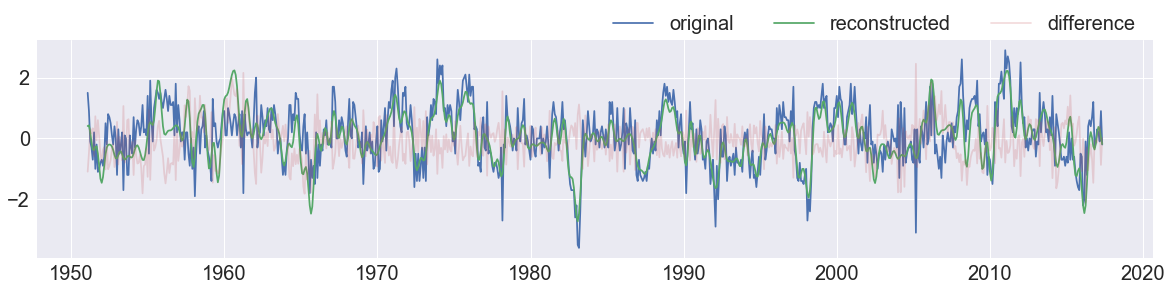

In [49]:
nt = np.size(to_evenly)
omega = 2*np.pi*freqs_foster
nf = np.size(freqs_foster)
ntau = np.size(tau_foster)
a_1 = coeff_foster.real
a_2 = coeff_foster.imag
# print(np.shape(a_1))

rec_ts = np.zeros(np.size(to_evenly))
for k in range(nf):
    for j in range(ntau):
        dz = omega[k] * (to_evenly - tau_foster[j])
        phi_1 = np.cos(dz)
        phi_2 = np.sin(dz)
        
        rec_ts += (a_1[j, k]*phi_1 + a_2[j, k]*phi_2)/ntau


sns.set(style="darkgrid", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to_evenly, Xo_evenly, label='original')  # plot the original time seires
plt.plot(t, rec_ts, label='reconstructed')  # plot the reconstructed time seires
plt.plot(t, rec_ts-Xo_evenly, label='difference', alpha=0.2)  # plot the reconstructed time seires
plt.legend(fontsize=20, bbox_to_anchor=(1, 1.2), loc='upper right', ncol=3)

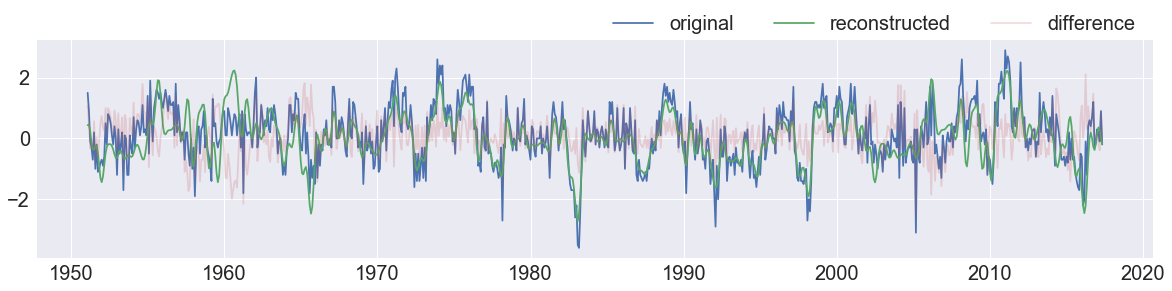

In [44]:
# print(np.min(to_evenly), np.max(to_evenly), np.size(to_evenly))
nt = np.size(to_evenly)
# t = np.linspace(to_evenly[0], to_evenly[-1], nt)
# print(np.min(t), np.max(t), np.size(t))
omega = 2*np.pi*freqs_evenly
nf = np.size(freqs_evenly)
ntau = np.size(tau_evenly)
a_1 = coeff_evenly.real
a_2 = coeff_evenly.imag
# print(np.shape(a_1))

rec_ts = np.zeros(np.size(to_evenly))
for k in range(nf):
    for j in range(ntau):
        dz = omega[k] * (to_evenly - tau_evenly[j])
        phi_1 = np.cos(dz)
        phi_2 = np.sin(dz)
        
        rec_ts += (a_1[j, k]*phi_1 + a_2[j, k]*phi_2)/ntau


sns.set(style="darkgrid", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to_evenly, Xo_evenly, label='original')  # plot the original time seires
plt.plot(t, rec_ts, label='reconstructed')  # plot the reconstructed time seires
plt.plot(t, rec_ts-Xo_evenly, label='difference', alpha=0.2)  # plot the reconstructed time seires
plt.legend(fontsize=20, bbox_to_anchor=(1, 1.2), loc='upper right', ncol=3)

### Check amplitude

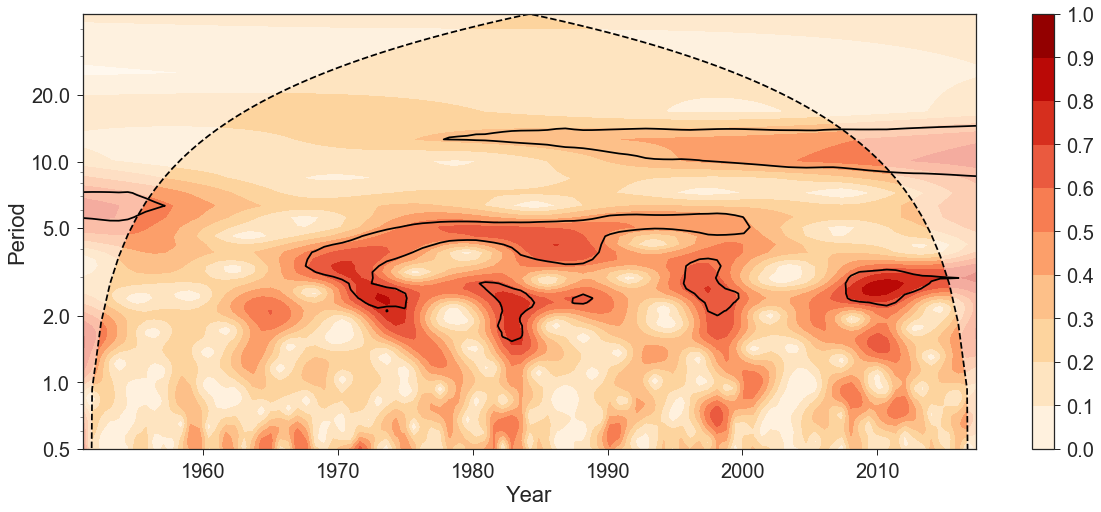

In [15]:
period_ticks = [0.5, 1, 2, 5, 10, 20]

fig = Spectral.plot_wwa(wwa_evenly, freqs, tau, coi=coi, AR1_q=AR1_q_evenly,
                        levels=np.linspace(0, 1, 11),
                        tick_range=np.linspace(0, 1, 11),
                        ylim=[np.min(period_ticks), np.max(coi)],
                        yticks=period_ticks,
                        plot_cone=True, plot_signif=True,
                       )

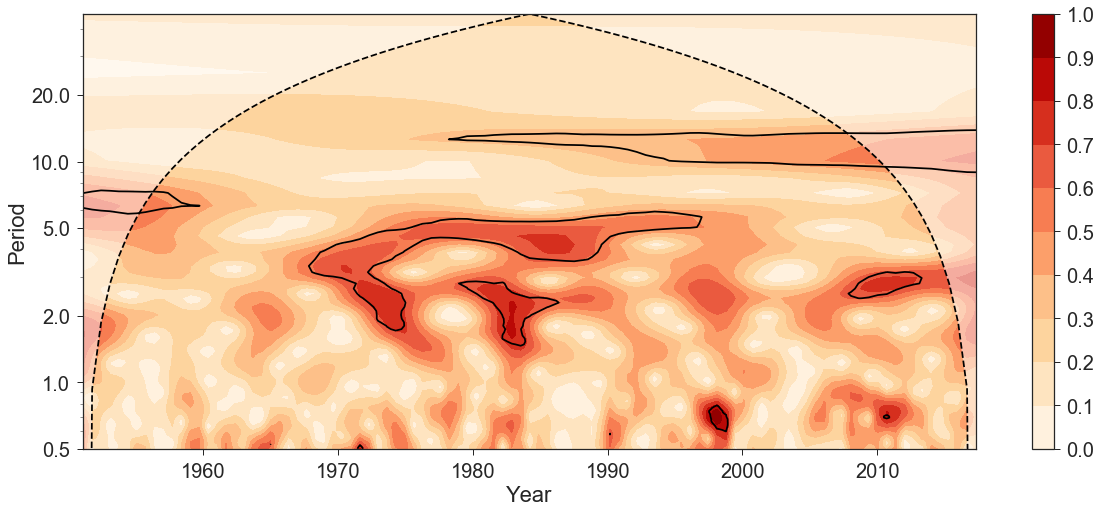

In [16]:
period_ticks = [0.5, 1, 2, 5, 10, 20]

fig = Spectral.plot_wwa(wwa_unevenly, freqs_unevenly, tau_unevenly, coi=coi, AR1_q=AR1_q_unevenly,
                        levels=np.linspace(0, 1, 11),
                        tick_range=np.linspace(0, 1, 11),
                        ylim=[np.min(period_ticks), np.max(coi)],
                        yticks=period_ticks,
                        plot_cone=True, plot_signif=True,
                       )

### Check PSD

In [14]:
tau = np.linspace(np.min(to_evenly), np.max(to_evenly), 101)
freqs = np.linspace(1/50, 2, 101)
psd_unevenly, freqs_unevenly, psd_ar1_q95_unevenly, psd_ar1_unevenly = Spectral.wwz_psd(Xo_unevenly, to_unevenly, freqs=freqs, tau=tau)
psd_evenly, freqs_evenly, psd_ar1_q95_evenly, psd_ar1_evenly = Spectral.wwz_psd(Xo_evenly, to_evenly, freqs=freqs, tau=tau)

Monte-Carlo simulations: 100%|██████████| 200/200 [00:08<00:00, 22.62it/s]


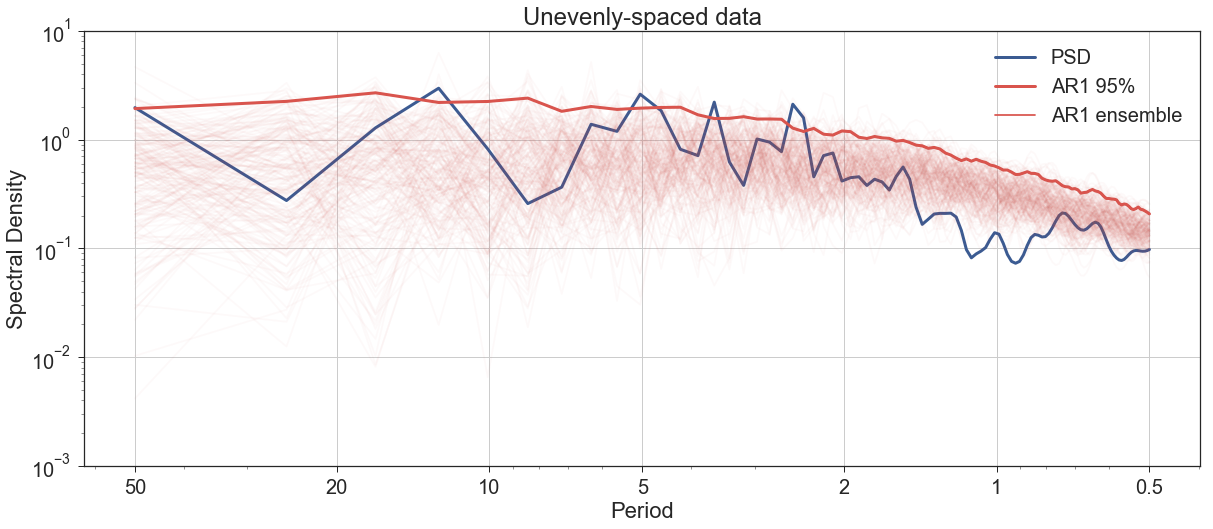

In [21]:
period_ticks = [0.5, 1, 2, 5, 10, 20, 50]

fig = Spectral.plot_psd(psd_unevenly, freqs_unevenly, plot_ar1=True, psd_ar1_q95=psd_ar1_q95_unevenly,
                        period_ticks=period_ticks, linewidth=3, ar1_linewidth=3,
                        psd_lim=[1e-3,1e1])

for i in range(np.shape(psd_ar1_unevenly)[0]):
    plt.plot(1/freqs, psd_ar1_unevenly[i, :], color=sns.xkcd_rgb["pale red"], alpha=0.03)

plt.plot(np.nan, np.nan, color=sns.xkcd_rgb["pale red"], alpha=1, label='AR1 ensemble')    
plt.legend()
plt.title('Unevenly-spaced data')
plt.savefig('./checkPSD_unevenly.png')

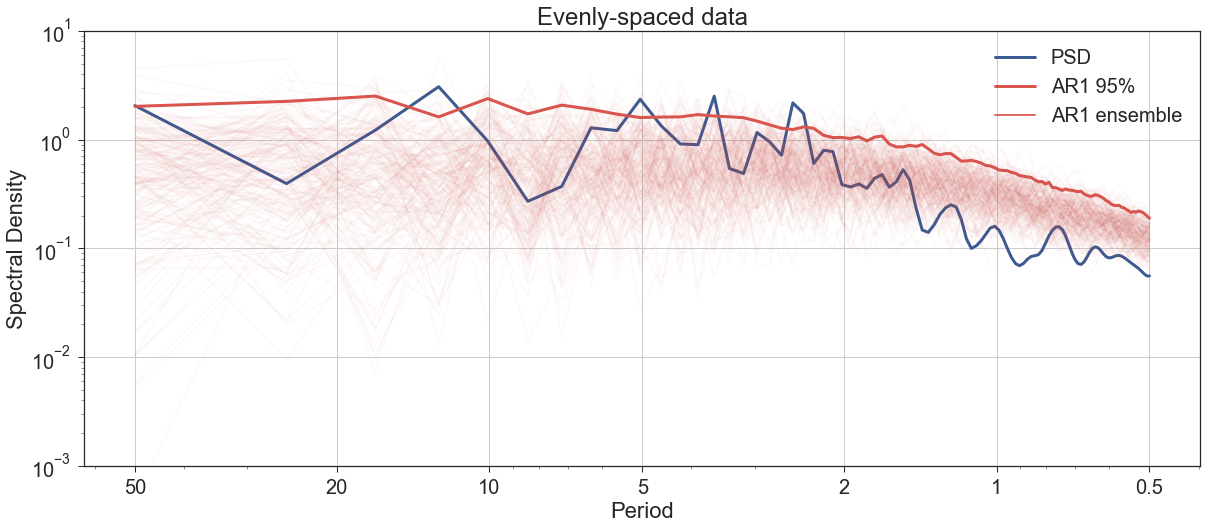

In [22]:
fig = Spectral.plot_psd(psd_evenly, freqs_evenly, plot_ar1=True, psd_ar1_q95=psd_ar1_q95_evenly,
                        period_ticks=period_ticks, linewidth=3, ar1_linewidth=3,
                        psd_lim=[1e-3, 1e1])
for i in range(np.shape(psd_ar1_evenly)[0]):
    plt.plot(1/freqs, psd_ar1_evenly[i, :], color=sns.xkcd_rgb["pale red"], alpha=0.03)

plt.plot(np.nan, np.nan, color=sns.xkcd_rgb["pale red"], alpha=1, label='AR1 ensemble')    
plt.legend()
plt.title('Evenly-spaced data')
plt.savefig('./checkPSD_evenly.png')